# [Learning to solve mixed-integer optimal control problems](https://arxiv.org/abs/2506.19646)

 A neural control policy is trained by solving a parametric mixed-integer optimal control problem as a differentiable program using [Differentiable predictive control (DPC) framework](https://www.sciencedirect.com/science/article/pii/S0959152422000981). Mixed-integer methodology is adopted from: https://arxiv.org/abs/2506.19646


## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install neuromancer

In [2]:
import torch
from neuromancer.system import Node, SystemPreview
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.functional import gumbel_softmax
from neuromancer.modules.activations import activations

## System model

We consider a simple conceptual thermal energy managment system represented by linear state-space formulation:

$$
{\bf x}_{k+1} = {\bf Ax}_k+ {\bf B} \begin{bmatrix}u_k, \\ \delta_k \end{bmatrix}+{\bf  E}d_k \\
 A=\begin{bmatrix}
a_1 - \lambda & \lambda \\
\lambda & a_2-\lambda
\end{bmatrix},\;
B=
\begin{bmatrix}
0.7\, b_1 & 0 \\
0.3\, b_1 & b_2
\end{bmatrix},\;
E=
\begin{bmatrix}
-e_1 & 0 \\
0 & -e_2
\end{bmatrix},
$$

with system states $x_1$ and $x_2$ representing thermal energy stored in two thermal energy storage tanks, $a_1$ and $a_2$ denote energy dissipation and $\lambda$ energy transition between the two tanks. Thermal energy is supplied by a heat pump $u\in\mathbb{R}$ with thermal efficiency $b_1$ and a fixed $70:30 \%$ split to $x_1$ and $x_2$, respectively. The second control input $\delta\in\mathbb\{0,1,2,3,4,5\}$ can be interpreted as heat rods of thermal efficiency $b_2$, supplying thermal energy to $x_2$. Energy consumption is represented as a disturbance variable $d\in\mathbf{R}$, split equally from both storage tanks. 

The conceputal dynamics model is inspired by examples in:

 https://arxiv.org/abs/2506.19646 and https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8815030 


In [3]:
a_1, a_2, _labmda_ = 0.95, 0.85, 0.0020 # model parameters
b_1, b_2, e_1, e_2 = 0.2, 0.0825, 0.1, 0.1

A = torch.tensor([[a_1 - _labmda_, _labmda_], # state dynamics
                [_labmda_, a_2 - _labmda_]])
B = torch.tensor([[0.7*b_1, 0],   # input dynamics
                    [0.3*b_1, b_2]])
E = torch.tensor([[-e_1], [-e_2]]) # disturbance gains

nx, nref = 2, 2 # number of states, number of references 
nu, ndelta, nd = 1, 1, 1 # number of continous inputs, integer inputs, and disturbances

dynamics = lambda x, u, d: x @ A.T + u @ B.T + d @ E.T # plant model

# process constraints
x1_min, x2_min = 0.0, 0.0
x1_max, x2_max, input_energy_max = 8, 4, 10
u_delta_min, u_delta_max = 0, 5 # integer control input bounds
u_c_min, u_c_max = 0.0, 7.0     # continous control input bounds

## Mixed-Integer Differentiable Predictive Control

Next we show how to solve the corresponding mixed-integer parametric optimal control problem using the [DPC method](https://www.sciencedirect.com/science/article/pii/S0959152422000981) implemented in Neuromancer.

**Differentiable Mixed-Integer Optimal Control Problem**

We pose the solution (control decisions) of a parametric mixed-integer optimal control problem as an output of neural control policy $[u_k, \delta_k] = \pi_\theta(\xi_k)$, parameterized by $\theta$. In this example the vector of control parameters $\xi_k$ includes initial condition $x_k$ and future windows of set points and disturbances $[r_k,\dots,r_{k+N}]$ and $[d_k,\dots,d_{k+N-1}]$, respectively. 

The optimal control problem is given as a standard Model Predictive Control formulation with reference tracking $\!\|x_k\!-\!r_k\|_Q^2$ and control smoothing objectives $\|u_{k+1}-u_{k}\|_R^2$, $ \|\delta_{k+1}-\delta_{k}\|^2_R$ as:
$$
\begin{align}
    \min_{\theta}  \, \!\mathbb{E}_{  \xi_k \sim P_{ \xi} }\,&\!  
    \bigg[\|x_N\!-\!r_N\|_Q^2
       \!+\!\sum_{k=0}^{N-1}
       \!\|x_k\!-\!r_k\|_Q^2+
       \|u_{k+1}-u_{k}\|_R^2+
       \|\delta_{k+1}-\delta_{k}\|^2_R\!\bigg]  \\
    \text{s.t.} \;
    {\bf x}_{k+1} &= {\bf Ax}_k+ {\bf B} \begin{bmatrix}u_k, \\ \delta_k \end{bmatrix}+{\bf  E}d_k  \\
    [u_k,\;\delta_k] & = {\pi}_{\theta}(\xi_k),  \\
        u_k  \in \mathcal{U}&,\;\delta_k \in \mathcal{D}, \quad \forall k\in\{0,1,\dots,N\!-\!1\},  \\
    x_k  \in \mathcal{X}&, \quad\quad\quad\quad\;\; \forall k\in\{0,1,\dots,N\},
\end{align}
$$

In short, we optimize the parameters of our control policy $\theta$ such that control objectives are minimized and process constraints $\mathcal{U}$, $\mathcal{X}$, and $\mathcal{D}$ are not violated. State constraints are relaxed as additional terms in loss function via penalty method, while input $\mathcal{U}$ and integrality $\mathcal{D}$ constraints are enforced within the computational graph. In this notebook, we show showcase two method for enforcing integrality constraints; via sigmoid relaxed rounding and via gumbel softmax categorical encoding.

## Constructing the neural control policy

Our control policy $\pi_\theta(\cdot)$ consits of two neural modules, one for continous control input and the other for discrete control input.

Note that depending on which integrality constraints enforcing method is chosen, output of the neural module varies. 

In [4]:
STE_methods = ['sigmoid', 'softmax']
STE_method = STE_methods[0]

nsteps = 20 # prediction horizon length    
integers = torch.arange(u_delta_min, u_delta_max+.1, dtype=torch.get_default_dtype()).unsqueeze(0) # vector of feasible integers

net_continous = blocks.MLP_bounds(insize=nx+(nref+nd)*(nsteps+1), outsize=nu, hsizes=[64,64], # neural module for continous control inputs
                            nonlin=activations['gelu'], min=u_c_min, max=u_c_max)

int_out_size = integers.shape[-1] if STE_method == 'softmax' else ndelta
net_integer = blocks.MLP(insize=nx+(nref+nd)*(nsteps+1), outsize=int_out_size, hsizes=[64,64], # neural module for integer control inputs
                            nonlin=activations['gelu'])

## Differentiable computational graph components

We leverage straight-through estimator paradigm to find differentiable surrogates of rounding and argmax functions. With rounding we leverage sigmoid gradients, while for categorical formulation, we leverage derivatives of softmax function.

In [5]:
dynamics_node = Node(dynamics, ['x','u','d'], ['x'], name='dynamics_model') # system dynamics

continous_policy_node = Node(net_continous, ['x','r','d'], ['u_c'], name='continous_input_policy')
integer_policy_node = Node(net_integer, ['x','r','d'], ['u_delta'], name='integer_input_policy')

if STE_method == 'sigmoid':
    def relaxed_round(x, slope=10.0): # differentiable nearest integer rounding via Sigmoid STE
        backward = (x-torch.floor(x)-0.5) # fractional value with rounding threshold
        return torch.round(x) + (torch.sigmoid(slope*backward) - torch.sigmoid(slope*backward).detach())
           #  forward pass↑     backward pass↑                                               no grad↑
    round_fn = lambda u_c, u_delta_relaxed: torch.cat((u_c, torch.clip(relaxed_round(u_delta_relaxed),u_delta_min,u_delta_max)), dim=-1)

elif STE_method == 'softmax':
    tau = 2 # temperature coefficient in (0,inf)
    round_fn = lambda u_c, u_delta_relaxed: torch.cat((u_c, gumbel_softmax(u_delta_relaxed, tau=tau, hard=True) @ integers.T), dim=-1)

rounding_node = Node(round_fn, input_keys=['u_c', 'u_delta'], output_keys=['u'], name='soft_rounding')

## Computational graph as closed-loop system

The computational graph is composed of two neural policy nodes, straight-through rounding node, and system dynamics. Note that we perform future preview of references and disturbance for both neural policy modules.

In [6]:
cl_system = SystemPreview([continous_policy_node, integer_policy_node, rounding_node, dynamics_node], # computational graph
                            nsteps=nsteps, name='cl_system', pad_mode='reflect',
                            preview_keys_map={'r': ['continous_input_policy', 'integer_input_policy'],  # preview references for both control policy modules
                                            'd': ['continous_input_policy', 'integer_input_policy']} )# preview disturbance for both control policy modules


## Generating synthetic dataset
Training dataset covers an expected probability distribution of the control parameters $\xi_k \sim P_{ \xi}$. Note that $x\sim\mathcal{U}(x_\text{min},x_{max})$, $x\sim\beta(0.2,1.4)$, while references are sampled as periodic signals.

In [7]:
num_data, batch_size = 14000, 2000
# sample disturbanecs
dist_magnitude = 5
dist_data = np.random.beta(0.2, 1.4, (num_data*(nsteps+1)))*dist_magnitude
dist_data_torch = torch.tensor(dist_data, dtype=torch.get_default_dtype()).reshape(num_data,nsteps+1,nd)
# sample references
ref1_baseline, ref2_baseline = 4, 2 # reference baseline
ref1_data = ref1_baseline + 1.5*np.sin(0.05*np.arange(num_data*(nsteps+1))).reshape(-1,1)
ref2_data = ref2_baseline + 0.5*np.cos(0.05*np.arange(num_data*(nsteps+1))).reshape(-1,1)
ref_data = np.concatenate((ref1_data, ref2_data), axis=-1)
ref_data_torch = torch.tensor(ref_data, dtype=torch.get_default_dtype()).reshape(num_data,nsteps+1,nref)
# sample initial conditions
x1_data = torch.empty(num_data, 1, 1).uniform_(x1_min, x1_max)
x2_data = torch.empty(num_data, 1, 1).uniform_(x2_min, x2_max)
x_data = torch.cat((x1_data, x2_data), dim=-1)

num_train_data = 10000 # training data splits to train data and development data

train_data = DictDataset({'x': x_data[:num_train_data], 'd': dist_data_torch[:num_train_data], 'r': ref_data_torch[:num_train_data]}, name='train')  # Split conditions into train and dev
dev_data = DictDataset({'x': x_data[num_train_data:], 'd': dist_data_torch[num_train_data:], 'r': ref_data_torch[num_train_data:]}, name='dev')
# instantiate data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, collate_fn=train_data.collate_fn)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size, collate_fn=dev_data.collate_fn)


## Control objectives

We define control objectives and process constraints using NeuroMANCER's symbolic variables.

In [8]:
u = variable('u') # control inputs
x = variable('x') # system states
r = variable('r') # referece
# control objectives
Q_control, R_smoothing = 10., 1. # reference tracking and control smoothing weights
tracking_loss = Q_control * ((x == r)^2)     # reference tracking loss
input_smoothing_loss = R_smoothing * ((u[:, 1:, :] == u[:, :-1, :])^2) # control smoothing loss
tracking_loss.name, input_smoothing_loss.name = 'tracking_loss', 'smoothing_loss'
# constraints
x1_lb, x1_ub = 50.*(x[:,:, [0]] >= x1_min), 50.*(x[:,:, [0]] <= x1_max)
x2_lb, x2_ub = 50.*(x[:,:, [1]] >= x2_min), 50.*(x[:,:, [1]] <= x2_max)
u_c_lb, u_c_ub = 50.*(u[:,:, [0]] >= u_c_min), 50.*(u[:,:, [0]] <= u_c_max)
x1_lb.name, x1_ub.name = 'x1_lb', 'x1_ub'
x2_lb.name, x2_ub.name = 'x2_lb', 'x2_ub'
u_c_lb.name, u_c_ub.name = 'u_lb', 'u_ub' 

constraints = [x1_lb, x1_ub, x2_lb, x2_ub, u_c_lb, u_c_ub]
loss = PenaltyLoss([tracking_loss, input_smoothing_loss], constraints)
problem = Problem([cl_system], loss)

## Optimization parameters 

In [9]:
optimizer = torch.optim.Adam(cl_system.parameters(), lr=0.0003, amsgrad=False, weight_decay=0.)
trainer = Trainer(
    problem,
    train_loader, dev_loader,
    optimizer=optimizer,
    epochs=200,
    train_metric='train_loss',
    dev_metric='dev_loss',
    eval_metric='dev_loss',
    warmup=20,
    patience=80,
)
best_model = trainer.train()    # start optimization
trainer.model.load_state_dict(best_model) # load best trained model

epoch: 0  train_loss: 38.19612503051758
epoch: 1  train_loss: 31.490840911865234
epoch: 2  train_loss: 26.153564453125
epoch: 3  train_loss: 24.102205276489258
epoch: 4  train_loss: 23.085948944091797
epoch: 5  train_loss: 21.733854293823242
epoch: 6  train_loss: 20.533374786376953
epoch: 7  train_loss: 19.374439239501953
epoch: 8  train_loss: 18.79062271118164
epoch: 9  train_loss: 18.294591903686523
epoch: 10  train_loss: 17.67174530029297
epoch: 11  train_loss: 17.00302505493164
epoch: 12  train_loss: 16.293359756469727
epoch: 13  train_loss: 15.664117813110352
epoch: 14  train_loss: 15.058454513549805
epoch: 15  train_loss: 14.476608276367188
epoch: 16  train_loss: 13.934478759765625
epoch: 17  train_loss: 13.420381546020508
epoch: 18  train_loss: 12.931361198425293
epoch: 19  train_loss: 12.483442306518555
epoch: 20  train_loss: 12.06452751159668
epoch: 21  train_loss: 11.668062210083008
epoch: 22  train_loss: 11.27194595336914
epoch: 23  train_loss: 10.878412246704102
epoch: 24  

<All keys matched successfully>

## Control policy test

Note that for testing, disturbance and reference signals are sampled from slightly different distributions than in training.

In [10]:
s_length = 100 # number of simulation steps
dists = np.random.beta(0.2, 1., (s_length+nsteps))*dist_magnitude # disturbances 
dists_torch = torch.tensor(dists, requires_grad=False, dtype=torch.get_default_dtype()).reshape(1,-1,nd)
ref1 = ref1_baseline + 1.*np.sin(0.1*np.arange(s_length+nsteps)).reshape(-1,1) # references
ref2 = ref2_baseline + 1.*np.cos(0.1*np.arange(s_length+nsteps)).reshape(-1,1)
refs = np.concatenate((ref1,ref2),axis=-1)
refs_torch = torch.tensor(refs, requires_grad=False, dtype=torch.get_default_dtype()).reshape(1,-1,nref)

sim_data = {'x': 3*torch.rand(1, 1, nx),
        'r': refs_torch,
        'd': dists_torch}

cl_system.nsteps = s_length
with torch.no_grad():
    trajectories = cl_system(sim_data) # simulate

## Plotting

C:\Users\bold914\AppData\Local\Temp\ipykernel_4836\1791729733.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  [ ( i.grid(), i.set_xlabel("time"), i.legend()) for i in ax.flat ]


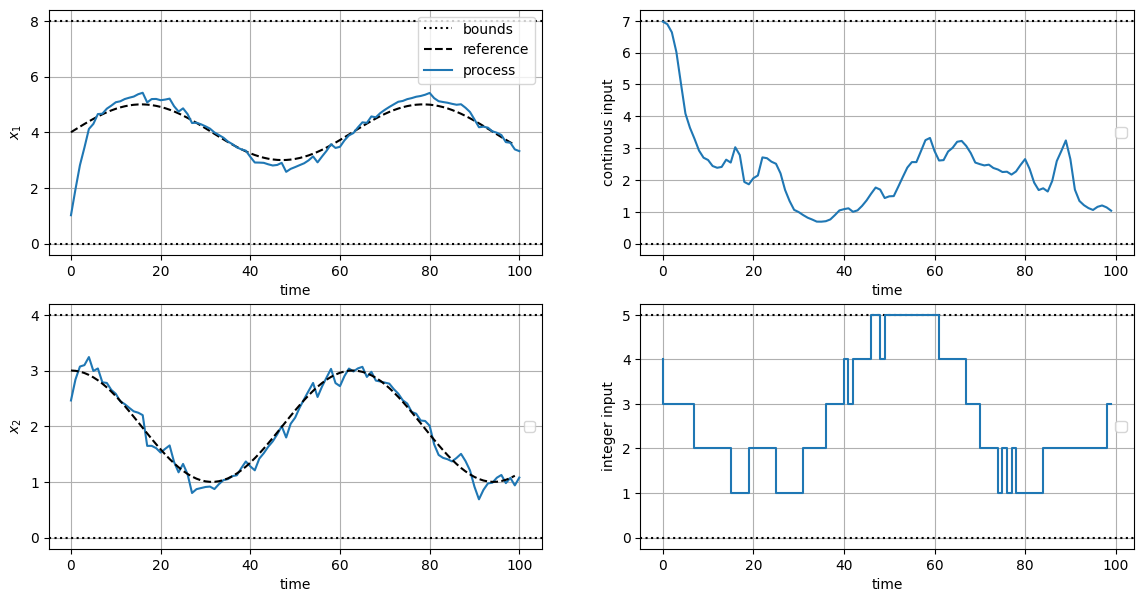

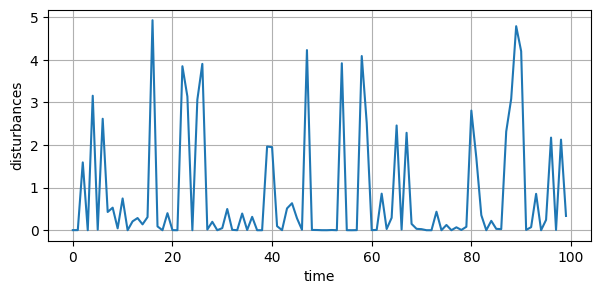

In [13]:
fig, ax = plt.subplots(2,2, figsize=(14,7))
ax[0,0].axhline(x1_min, linestyle=':', c='k', label='bounds'); ax[0,0].axhline(x1_max, linestyle=':', c='k')
ax[0,0].plot(trajectories['r'][0,:s_length,0], 'k--', label='reference'); ax[0,0].plot(trajectories['x'][0,:,0], label='process'); 
ax[1,0].plot(trajectories['x'][0,:,1]); ax[1,0].plot(trajectories['r'][0,:s_length,1], 'k--') 
[ax[1,0].axhline(i, linestyle=':', c='k') for i in [x2_min, x2_max]]
[ax[0,1].axhline(i, linestyle=':', c='k') for i in [u_c_min, u_c_max]]; ax[0,1].plot(trajectories['u'][0,:,0]); 
[ax[1,1].axhline(i, linestyle=':', c='k') for i in [u_delta_min, u_delta_max]]; 
ax[1,1].step(np.arange(0,len(trajectories['u'][0,:,1])),trajectories['u'][0,:,1], linewidth=1.5)

[ ( i.grid(), i.set_xlabel("time"), i.legend()) for i in ax.flat ]
ax[0,0].set_ylabel('$x_1$'); ax[1,0].set_ylabel('$x_2$'); ax[0,1].set_ylabel('continous input'); ax[1,1].set_ylabel('integer input')
plt.show()

plt.figure(figsize=(7,3)); plt.plot(trajectories['d'][0,:s_length,0]); 
plt.ylabel('disturbances'); plt.xlabel('time'); plt.grid()
plt.show()